In [1]:
!pip install transformers datasets
!pip install torch torchvision torchaudio
!pip install datasets


In [ ]:
from transformers import pipeline
import random
import re
from collections import Counter
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import matplotlib.pyplot as pl
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from sklearn.metrics import classification_repor
import pandas as pd
from transformers import pipeline


## **Function: `load_and_clean_data`**
This function loads a dataset, cleans the text, and maps labels to numerical values.

### **Parameters:**
- `dataset_name` (str): The name of the dataset to be loaded.
- `label_mapping` (dict): A dictionary mapping label names to numerical values.

### **Process:**
1. **Load the dataset**: Uses the `load_dataset` function to load the dataset.
2. **Extract texts and labels**: Retrieves text data and corresponding labels from the training set.
3. **Clean the text**:
   - Converts text to lowercase.
   - Removes extra spaces.
   - Keeps only Amharic punctuation (`።፡፣`) and removes other special characters.
4. **Map labels to numerical values**: Converts textual labels into numbers using `label_mapping`.

### **Returns:**
- `texts` (list): A list of cleaned text data.
- `numerical_labels` (list): A list of corresponding numerical labels.

---

## **Function: `plot_dataset_distribution`**
This function visualizes the distribution of labels in the dataset.

### **Parameters:**
- `labels` (list): A list of numerical labels.
- `title` (str, optional): Title for the plot (default is `"Dataset Label Distribution"`).

### **Process:**
1. **Count label frequencies**: Uses `Counter` to count occurrences of each label.
2. **Print the distribution**: Displays label counts in the console.
3. **Plot the distribution**:
   - Uses a bar chart to visualize label frequencies.
   - Sets axis labels, title, and tick marks for better readability.

---



Label Distribution:
Label 2: 2240
Label 1: 4477
Label 0: 5283


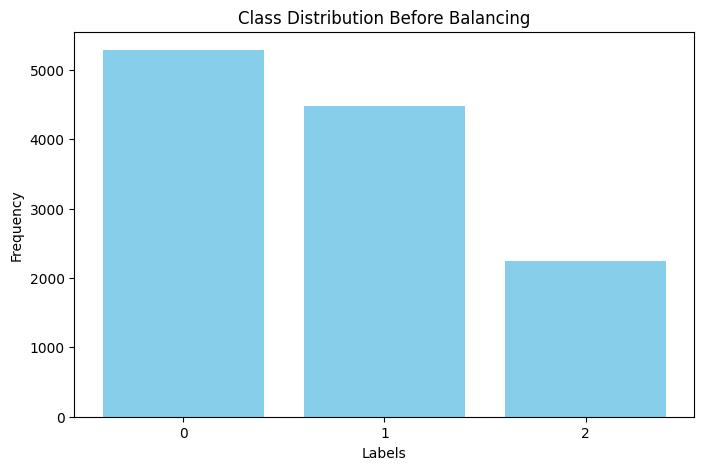

In [19]:

def load_and_clean_data(dataset_name, label_mapping):
    """
    Load the dataset, clean texts, and map labels to numerical.
    """
    # Load dataset
    dataset = load_dataset(dataset_name)
    texts = dataset["train"]["text"]
    labels = dataset["train"]["label"]

    # Clean text
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
        text = re.sub(r'[^\w\s።፡፣]', '', text)  # Keep Amharic punctuation
        return text.strip()

    texts = [clean_text(text) for text in texts]
    numerical_labels = [label_mapping[label] for label in labels]

    return texts, numerical_labels

def plot_dataset_distribution(labels, title="Dataset Label Distribution"):
    """
    Display and plot the distribution of labels in the dataset.

    Parameters:
      labels (list): A list of numerical labels.
      title (str): Title for the plot.
    """
    # Count the frequency of each label
    label_counts = Counter(labels)

    # Print the distribution
    print("Label Distribution:")
    for label, count in label_counts.items():
        print(f"Label {label}: {count}")

    # Prepare data for plotting
    keys = sorted(label_counts.keys())
    values = [label_counts[k] for k in keys]

    # Plot the distribution with a bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(keys, values, color="skyblue")
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(keys)
    plt.show()

# Example usage:
label_mapping = {"hate": 0, "normal": 1, "offensive": 2}
texts, labels = load_and_clean_data("uhhlt/amharichatespeechranlp", label_mapping)

# Show the distribution of labels before balancing the dataset
plot_dataset_distribution(labels, title="Class Distribution Before Balancing")


## **Function: `balance_data`**
This function balances the dataset by downsampling each class to a specified target sample size.

### **Parameters:**
- `texts` (list): A list of text data.
- `labels` (list): A list of corresponding labels.
- `target_samples` (int): The maximum number of samples to retain per class.

### **Process:**
1. **Pair texts and labels**: Combines them into a list of tuples.
2. **Count label occurrences**: Uses `Counter` to determine the number of samples for each class.
3. **Downsample if necessary**:
   - If a class has more than `target_samples`, it is randomly sampled down to the limit.
4. **Shuffle the balanced dataset**: Ensures randomness in the final dataset.
5. **Return balanced texts and labels**.

### **Returns:**
- `balanced_texts` (list): A list of downsampled text data.
- `balanced_labels` (list): Corresponding labels.

---

## **Function: `plot_dataset_distribution`**
This function visualizes the distribution of labels in the dataset.

### **Parameters:**
- `labels` (list): A list of numerical labels.
- `title` (str, optional): The title for the plot (default is `"Dataset Distribution"`).

### **Process:**
1. **Count label frequencies**: Uses `Counter` to determine the number of samples per class.
2. **Print the label distribution**: Displays the number of occurrences of each label in the console.
3. **Plot the distribution**:
   - Uses a bar chart to visualize label counts.
   - Configures axis labels, title, and tick marks for readability.




Label Distribution:
Label 1: 2240
Label 2: 2240
Label 0: 2240


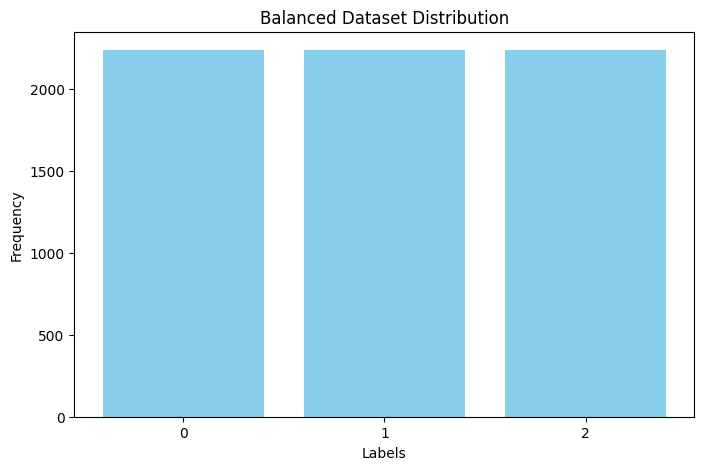

In [20]:


def balance_data(texts, labels, target_samples):
    """
    Balance dataset by downsampling all classes to the target sample size.
    """
    data = list(zip(texts, labels))
    label_counts = Counter(labels)

    balanced_data = []
    for label in label_counts:
        # Extract all entries for the current class
        class_data = [text for text, lbl in data if lbl == label]
        # Downsample if necessary
        if len(class_data) > target_samples:
            class_data = random.sample(class_data, target_samples)
        balanced_data.extend(list(zip(class_data, [label] * len(class_data))))

    # Shuffle the balanced data
    random.shuffle(balanced_data)
    balanced_texts, balanced_labels = zip(*balanced_data)
    return balanced_texts, balanced_labels

def plot_dataset_distribution(labels, title="Dataset Distribution"):
    """
    Plot the distribution of labels in a dataset.

    Parameters:
      labels (list): A list of labels.
      title (str): The title for the plot.
    """
    # Count frequency of each label
    label_counts = Counter(labels)

    # Print label counts
    print("Label Distribution:")
    for label, count in label_counts.items():
        print(f"Label {label}: {count}")

    # Prepare data for plotting
    keys = sorted(label_counts.keys())
    values = [label_counts[k] for k in keys]

    # Plot the distribution as a bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(keys, values, color="skyblue")
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(keys)
    plt.show()

# Assuming you've already loaded and cleaned your data:
# texts, labels = load_and_clean_data("uhhlt/amharichatespeechranlp", {"hate": 0, "normal": 1, "offensive": 2})

# Balance the dataset
balanced_texts, balanced_labels = balance_data(texts, labels, target_samples=2240)

# Display distribution of the balanced dataset
plot_dataset_distribution(balanced_labels, title="Balanced Dataset Distribution")


## **Function: `tokenize_and_split`**
This function tokenizes text data and splits it into training, validation, and test sets.

### **Parameters:**
- `texts` (list): A list of text samples.
- `labels` (list): A list of corresponding labels.
- `model_name` (str): The name of the pretrained tokenizer model (e.g., `"xlm-roberta-base"`).

### **Process:**
1. **Load the tokenizer**: Uses `AutoTokenizer.from_pretrained(model_name)`.
2. **Define a tokenization function**:
   - Tokenizes the input text while applying padding (`max_length`) and truncation.
3. **Create a dataset**: Converts `texts` and `labels` into a `Dataset` object.
4. **Apply tokenization**: Maps the `tokenize_function` over the dataset.
5. **Split the dataset**:
   - **80% Train / 20% Test** split.
   - **10% of Train set is further split into Validation**.
6. **Return** the datasets.

### **Returns:**
- `train_dataset`: The training dataset (72% of the original data).
- `val_dataset`: The validation dataset (8% of the original data).
- `test_dataset`: The test dataset (20% of the original data).



In [4]:
def tokenize_and_split(texts, labels, model_name):
    """
    Tokenize text data and split into training, validation, and test sets.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True)

    dataset = Dataset.from_dict({"text": texts, "label": labels})
    tokenized_dataset = dataset.map(tokenize_function, batched=True)

    # Split data
    train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
    train_val_split = train_test_split['train'].train_test_split(test_size=0.1)
    return train_val_split['train'], train_val_split['test'], train_test_split['test']
train_dataset, val_dataset, test_dataset = tokenize_and_split(balanced_texts, balanced_labels, model_name="xlm-roberta-base")


Map:   0%|          | 0/6720 [00:00<?, ? examples/s]

## **Function: `train_model`**
This function trains a sequence classification model with early stopping.

### **Parameters:**
- `train_dataset` (Dataset): The training dataset.
- `val_dataset` (Dataset): The validation dataset.
- `model_name` (str): The name of the pretrained transformer model (e.g., `"xlm-roberta-base"`).
- `num_labels` (int): The number of unique labels in the dataset.

---

### **Process:**
1. **Load the Pretrained Model**:
   - Uses `AutoModelForSequenceClassification` with the specified number of labels.
   - Moves the model to GPU (`cuda`) for faster training.

2. **Define Evaluation Metrics**:
   - Computes **accuracy**, **precision**, **recall**, and **F1-score** using `precision_recall_fscore_support` and `accuracy_score`.

3. **Set Training Arguments**:
   - **Output Directory:** `./results`
   - **Evaluation Strategy:** Evaluates the model at the end of every epoch.
   - **Learning Rate:** `2e-5`
   - **Batch Size:** `32`
   - **Number of Epochs:** `50`
   - **Model Saving Strategy:** Saves the best model based on F1-score.
   - **Early Stopping:** Stops training if performance does not improve for 5 epochs.

4. **Initialize Trainer**:
   - Uses the `Trainer` class to manage training.
   - Includes `EarlyStoppingCallback(early_stopping_patience=5)`.

5. **Train the Model**:
   - Calls `trainer.train()` to start training.



In [5]:
def train_model(train_dataset, val_dataset, model_name, num_labels):
    """
    Train a sequence classification model with early stopping.
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to("cuda")

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = np.argmax(pred.predictions, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
        acc = accuracy_score(labels, preds)
        return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        num_train_epochs=50,
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_steps=50,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
    )
    trainer.train()
    return trainer
trainer = train_model(train_dataset, val_dataset, model_name="xlm-roberta-base", num_labels=3)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yonatangirma61 (yonatangirma61-yonatan-abebe) 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.878500,0.797979,0.652416,0.670989,0.652416,0.646215
2,0.768800,0.761417,0.654275,0.654823,0.654275,0.653100
3,0.682800,0.826694,0.659851,0.702148,0.659851,0.651916
4,0.628100,0.764661,0.708178,0.716180,0.708178,0.706056
5,0.502300,0.811407,0.682156,0.683640,0.682156,0.682066
6,0.405100,0.946265,0.639405,0.671388,0.639405,0.636922
7,0.382100,0.844394,0.713755,0.715364,0.713755,0.712745
8,0.269400,1.208365,0.678439,0.702459,0.678439,0.672030
9,0.227300,1.245196,0.689591,0.694410,0.689591,0.690094
10,0.197700,1.194948,0.704461,0.710794,0.704461,0.704096


## **Function: `plot_loss`**
This function plots the training and validation loss over epochs, ensuring both losses are properly aligned.

### **Parameters:**
- `trainer` (Trainer): The trained model's `Trainer` object, which contains the training logs.

---

### **Process:**
1. **Extract Loss Values:**
   - Retrieves training loss (`"loss"`) and validation loss (`"eval_loss"`) from `trainer.state.log_history`.

2. **Ensure Alignment:**
   - Since the number of recorded training and validation losses may differ, it trims both lists to the same minimum length.

3. **Plot the Loss Curve:**
   - X-axis: Epochs.
   - Y-axis: Loss values.
   - Training loss is plotted in **blue**.
   - Validation loss is plotted in **orange**.
   - Adds labels, title, and a legend for better readability.



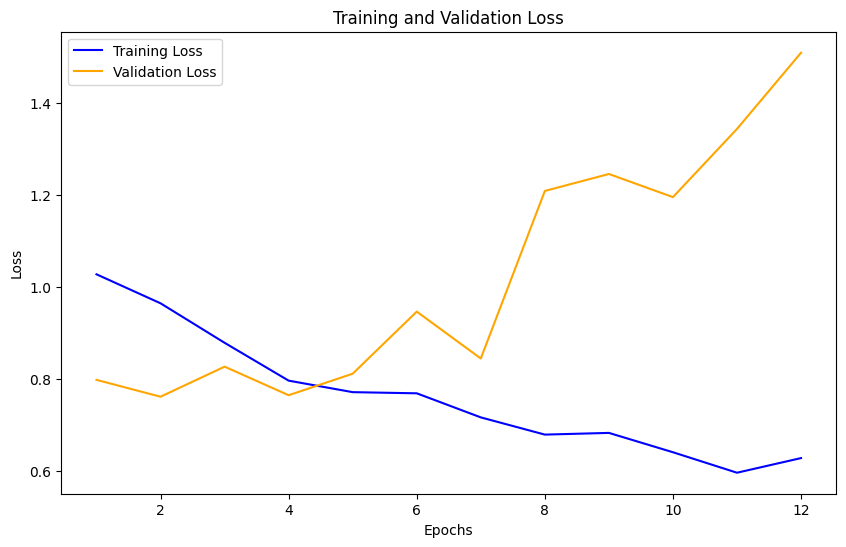

In [8]:
def plot_loss(trainer):
    """
    Plot training and validation loss over epochs, ensuring alignment.
    """
    logs = trainer.state.log_history
    train_loss = [log["loss"] for log in logs if "loss" in log]
    eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

    # Align lengths by truncating to the smaller size
    min_length = min(len(train_loss), len(eval_loss))
    train_loss = train_loss[:min_length]
    eval_loss = eval_loss[:min_length]
    epochs = range(1, min_length + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label="Training Loss", color="blue")
    plt.plot(epochs, eval_loss, label="Validation Loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
plot_loss(trainer)



## **Function: `plot_confusion_matrix`**
This function generates and displays a **confusion matrix** for predictions on the test dataset.

---

### **Parameters:**
- `trainer` (Trainer): The trained model's `Trainer` object used to make predictions.
- `test_dataset` (Dataset): The dataset containing test samples for evaluation.

---

### **Process:**
1. **Generate Predictions:**
   - Uses `trainer.predict(test_dataset)` to get model predictions.
   - Extracts **true labels** (`y_true`) and **predicted labels** (`y_pred`).

2. **Compute Confusion Matrix:**
   - Uses `confusion_matrix(y_true, y_pred)` from `sklearn.metrics`.

3. **Plot the Confusion Matrix:**
   - Uses `ConfusionMatrixDisplay` to display the matrix.
   - Labels the classes as `["Hate", "Normal", "Offensive"]`.
   - Applies the `"viridis"` colormap for visualization.
   - Titles the plot as **"Confusion Matrix"**.




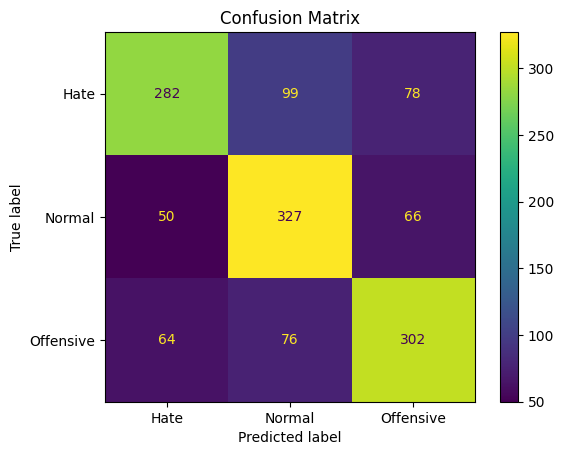

In [9]:
def plot_confusion_matrix(trainer, test_dataset):
    """
    Plot confusion matrix for predictions on the test set.
    """
    predictions = trainer.predict(test_dataset)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hate", "Normal", "Offensive"])
    disp.plot(cmap="viridis")
    plt.title("Confusion Matrix")
    plt.show()
plot_confusion_matrix(trainer, test_dataset)


In [14]:
# Save the model
trainer.save_model("./results")

# Save the tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
tokenizer.save_pretrained("./results")


('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/sentencepiece.bpe.model',
 './results/added_tokens.json',
 './results/tokenizer.json')

## **Function: `display_predictions_vs_ground_truth`**
This function compares **model predictions** against **ground truth labels** on the test dataset.

---

### **Parameters:**
- `trainer` (Trainer): A Hugging Face Trainer instance used for predictions.
- `test_dataset` (Dataset): The test dataset containing text samples and labels.
- `num_samples` (int, default=20): Number of samples to display in the comparison table.
- `label_mapping` (dict, optional): A dictionary mapping numerical labels to human-readable class names.  
  Example: `{0: "Hate", 1: "Normal", 2: "Offensive"}`.

---

### **Process:**
1. **Generate Predictions:**
   - Uses `trainer.predict(test_dataset)` to obtain predicted labels.
   - Extracts **true labels** (`y_true`) and **predicted labels** (`y_pred`).

2. **Retrieve and Format Text Samples:**
   - Extracts corresponding text samples from `test_dataset["text"]`.
   - Truncates text to 100 characters for cleaner display.

3. **Map Labels to Readable Class Names (if provided):**
   - Converts numerical labels to their mapped names.

4. **Create a Pandas DataFrame for Display:**
   - Shows **text samples**, **ground truth labels**, and **model predictions**.

5. **Display Classification Report:**
   - Uses `classification_report(y_true, y_pred)` from `sklearn.metrics` for performance evaluation.
   - If `label_mapping` is provided, labels are mapped for readability.

---

### **Returns:**
- **Prints a table** with **text samples, ground truth labels, and model predictions**.
- **Prints a classification report** showing precision, recall, and F1-score for each class.






In [17]:


def display_predictions_vs_ground_truth(trainer, test_dataset, num_samples=20, label_mapping=None):
    """
    Display and compare ground truth labels with predictions on the test set.

    Parameters:
      trainer: A HuggingFace Trainer instance (or similar) with a .predict() method.
      test_dataset: A HuggingFace Dataset object containing the test set. Assumed to have a "text" column.
      num_samples: The number of samples to display (default: 20 sample rows).
      label_mapping: Optional dictionary mapping numerical labels to human-readable label names.
                     For example: {0: "Hate", 1: "Normal", 2: "Offensive"}
    """
    # Obtain predictions from the trainer
    predictions = trainer.predict(test_dataset)
    y_pred = predictions.predictions.argmax(axis=1)
    y_true = predictions.label_ids

    # Extract the original texts (assuming the test_dataset has a "text" field)
    texts = [test_dataset[i]["text"] for i in range(len(test_dataset))]

    # Optionally map labels to their names using label_mapping
    if label_mapping:
        y_true_named = [label_mapping.get(label, label) for label in y_true]
        y_pred_named = [label_mapping.get(label, label) for label in y_pred]
    else:
        y_true_named = y_true
        y_pred_named = y_pred

    # Create a Pandas DataFrame to show the results nicely.
    # We truncate the text to 100 characters for display purposes.
    df_results = pd.DataFrame({
        "Text": [text if len(text) <= 100 else text[:100] + "..." for text in texts[:num_samples]],
        "Ground Truth": y_true_named[:num_samples],
        "Prediction": y_pred_named[:num_samples]
    })

    print("Sample Predictions vs. Ground Truth:")
    print(df_results)

    # Optional: Display a detailed classification report for the entire test set.
    print("\nClassification Report:")
    if label_mapping:
        # Ensure the target names are sorted by label index.
        sorted_labels = [label_mapping[i] for i in sorted(label_mapping)]
        print(classification_report(y_true, y_pred, target_names=sorted_labels))
    else:
        print(classification_report(y_true, y_pred))






In [18]:
# Assuming your label mapping is something like this:
label_mapping = {0: "Hate", 1: "Normal", 2: "Offensive"}

# Display sample predictions (first 20 test samples) plus a full classification report.
display_predictions_vs_ground_truth(trainer, test_dataset, num_samples=20, label_mapping=label_mapping)


Sample Predictions vs. Ground Truth:
                                                 Text Ground Truth Prediction
0   user ነፍስህ በኃጢአት ተጠምቃለች ፡፡ እስከመቼ እግዚአብሔርን ትክዳለህ...    Offensive  Offensive
1   user user አንተ እራስህ ገና ለገና አንድ መሀይም ተሳደበ ብለህ ወደ...    Offensive  Offensive
2   user የፖለቲካ ድርጅት ደጋፊ ላትሆን ትጭላለህ ግን የኣብይን ቂጥ በየፖ...    Offensive  Offensive
3   user አማራ በታሪኩ እንደዚህ ተዋርዶና ተበድሎማ ያውቃል። እሱም በትህነ...         Hate     Normal
4   user user ቆምጬ ሽንታም ሰርግ ላይ መቶኮስ ጉራ መሸለል እንጂ ቆምጬ...         Hate  Offensive
5   user user ተይዘሃል የሚባለው ነገርስ  በ24 ሰዓት ውስጥ ለዚህ ትው...    Offensive  Offensive
6   በአህያ ውሽማ ተለማምዶ ሚስት ያገባ ፋኖ ልጁን ኩራባቸው ብሎ ስም የሚያወ...         Hate     Normal
7   user ፈጣሪያችንን ይዘን አንተን አስከትለን መቼም ምድረባንዳና ነጫጭባን...         Hate     Normal
8   ethiopia እንደ ኢሳት ዘገባ ከሆነ ዛሬ በወለጋ ታጣቂዎች ጥቃት ኣድር...       Normal       Hate
9   አማረኛ መናገር አማራ አያረግም ይህ የትግራይ ፋሽስት ነት ማለቴ ናቲ ተብ...         Hate       Hate
10    user user user user ባንዳነታቹ ከድሮም ጀምሮ እንደሆነ እናካለን         Hate     Normal
11                  የመሰቦ ሲሚ

# **Function: `interactive_inference`**

This function launches an **interactive text classification loop** where users can enter text, and the model will predict its category along with a confidence score.

## **Parameters:**
- **`model_dir`** (str, default=`"./results"`):  
  Path to the directory where the fine-tuned model and tokenizer are stored.
- **`device`** (int, default=`0`):  
  - `0`: Runs inference on **GPU** (if available).  
  - `-1`: Runs inference on **CPU**.

---

## **How It Works:**
1. **Loads the Model and Tokenizer**  
   - Uses `pipeline("text-classification")` from 🤗 **Hugging Face Transformers** to load the fine-tuned model from `model_dir`.
  
2. **Starts an Interactive Loop**  
   - Prompts the user to enter a text input.
   - If the user types `"exit"`, the loop terminates.
  
3. **Performs Inference**  
   - Feeds the input text into the model.
   - Retrieves the **predicted label** and **confidence score**.
   - Prints the results in the format:  
     ```plaintext
     Prediction: <label> (Confidence: <score>)
     ```
  
4. **Repeats Until the User Exits**  
   - The loop continues until `"exit"` is typed.




In [16]:


def interactive_inference(model_dir="./results", device=0):
    """
    Launch an interactive inference loop that loads a fine-tuned model and tokenizer,
    takes user input, and then prints out the predicted label and its confidence.

    Parameters:
        model_dir (str): Path to the directory where the model and tokenizer are saved.
        device (int): Device index for computation (0 for GPU, -1 for CPU).
    """
    # Load the inference pipeline using the model and tokenizer from model_dir.
    infer_pipe = pipeline("text-classification", model=model_dir, tokenizer=model_dir, device=device)

    print("Enter text to classify (type 'exit' to quit):")

    while True:
        user_input = input("Input: ").strip()
        if user_input.lower() == "exit":
            print("Exiting...")
            break

        # Make a prediction on the provided text.
        prediction = infer_pipe(user_input)
        label = prediction[0]['label']
        score = prediction[0]['score']
        print(f"Prediction: {label} (Confidence: {score:.2f})")

# To run the interactive inference loop, call the function:
if __name__ == "__main__":
    interactive_inference()


Device set to use cuda:0


Enter text to classify (type 'exit' to quit):
Input: የትግራይ ዳያስፖራ አገራቹ ግቡ ቢባሉ፣ ባለማጋነን ትግርኛ ተናጋሪ አሜሪካ ውስጥ ይታጣ ነበረ??
Prediction: LABEL_1 (Confidence: 0.47)
Input: የትግራይ ዳያስፖራ አገራቹ ግቡ ቢባሉ፣ ባለማጋነን ትግርኛ ተናጋሪ አሜሪካ ውስጥ ይታጣ ነበረ??
Prediction: LABEL_1 (Confidence: 0.47)
Input: የምወድሽ፣ የምሳሳልሽ፣ እናቴ፣ ሃገሬ፣ ኢትዮጵያ! ከላይ አረንጓዴ አለ ኣ? ከመሐል ደሞ ቢጫ ከስር ደሞ ቀይ... በቃ ሁሌም በእነሱ ነው መድመቅ የምፈልገው...
Prediction: LABEL_1 (Confidence: 0.98)
Input:  ቀን ይቅርታን የምትለምኑበት እና ህመም እና ተስፋ መቁረጥ እንጂ ሌላ ምንም ያልተተዉበት ቀን የሚመጣው ክፉ ይመጣል እናም ሕይወትዎን በመጨረሻ በቀስታ እና በአሳዛኝ ሁኔታ የሰው ልጅን በመጨረሻ ይወስዳል ፡፡
Prediction: LABEL_1 (Confidence: 0.98)
Input: ቆመክ ሞተካል ሱፍ ለብስክ ባለጌ ወንበር ላይ ሆነክ ሳይሆን ሄድ 
Prediction: LABEL_2 (Confidence: 0.75)
Input: የትግራይ ዳያስፖራ አገራቹ ግቡ ቢባሉ፣ ባለማጋነን ትግርኛ ተናጋሪ አሜሪካ ውስጥ ይታጣ ነበረ??
Prediction: LABEL_1 (Confidence: 0.47)
Input:  በዚህ ሶስት ዓመት ውጥንቅጡ በወጣባት አገር ዋናውን ጁንታ
Prediction: LABEL_0 (Confidence: 0.95)
Input: exit
Exiting...
